# Competição ITA

Lucas Szavara - 12690087
Maria Victória Brandão Barros - 12608692

In [8]:
from imblearn.combine import SMOTEENN
from keras.models import Sequential
from keras.layers import Dense, Dropout
from metpy.io import parse_metar_to_dataframe, parse_metar_file
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import naive_bayes, metrics, model_selection, tree, neighbors, ensemble
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from xgboost import XGBClassifier

2024-04-30 11:18:06.021858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 11:18:11.539123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Importando os dados

In [9]:
df = pd.read_csv('./public.csv')
df.head()

flightid              hora_ref origem destino  \
0  504a62621cd231d6ab67e674ce538cd3  2022-06-01T01:00:00Z   SBCF    SBFL   
1  b0fd0f83644625ecc21f5261e8e5e347  2022-06-01T01:00:00Z   SBPA    SBFL   
2  1210f0ca07ddca00d09a3e02d3b100d8  2022-06-01T01:00:00Z   SBSP    SBCF   
3  b25032f34507cce285ee779446496568  2022-06-01T01:00:00Z   SBGR    SBCT   
4  00762a9892ecba7c66d1d87800d38cac  2022-06-01T01:00:00Z   SBSP    SBSV   

                                    url_img_satelite metaf  \
0  http://satelite.cptec.inpe.br/repositoriogoes/...   NaN   
1  http://satelite.cptec.inpe.br/repositoriogoes/...   NaN   
2  http://satelite.cptec.inpe.br/repositoriogoes/...   NaN   
3  http://satelite.cptec.inpe.br/repositoriogoes/...   NaN   
4  http://satelite.cptec.inpe.br/repositoriogoes/...   NaN   

                                               metar  prev_troca_cabeceira  \
0  METAR SBFL 010000Z 17009KT 140V200 9999 BKN030...                     0   
1  METAR SBFL 010000Z 17009KT 140V200 9999 BKN030...                     0   
2      METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018=                     0   
3  METAR SBCT 010000Z 10006KT 7000 -RA BKN004 OVC...                     0   
4  METAR SBSV 010000Z 11008KT 9999 FEW023 27/21 Q...                     0   

   troca_cabeceira_hora_anterior  espera  
0                              1     0.0  
1                              1     0.0  
2                              0     0.0  
3                              0     0.0  
4                              1     0.0

In [10]:
df.shape

(302399, 10)

# Tratamento de dados

Primeiro mapeamos as informações metereológicas

In [ ]:

metars =  []
df['metar'] = df['metar'].fillna('')
for i, metar in enumerate(df['metar']):
    try:
        metars.append(parse_metar_to_dataframe(metar))
    except Exception as err:
        print(err)
        metars.append(pd.DataFrame([[None] * len(metars[i-1].columns)], columns=metars[i-1].columns))
metar = pd.concat(metars)
metar.head()

In [ ]:
colunas_metar = metar.columns
metar.head()

In [ ]:

df = pd.merge(df, metar.reset_index(), left_index=True, right_index=True)
df.to_csv('./dados_tratados.csv')


Agora, removemos as colunas constantes

In [11]:
df = pd.read_csv('./dados_tratados.csv')
df = df.loc[:, (df != df.iloc[0]).any()] 

/tmp/ipykernel_432048/2456479007.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./dados_tratados.csv')


In [12]:
df.columns

Index(['Unnamed: 0', 'flightid', 'hora_ref', 'origem', 'destino',
       'url_img_satelite', 'metaf', 'metar', 'prev_troca_cabeceira',
       'troca_cabeceira_hora_anterior', 'espera', 'index', 'station_id',
       'latitude', 'longitude', 'elevation', 'date_time', 'wind_direction',
       'wind_speed', 'wind_gust', 'visibility', 'current_wx1', 'current_wx2',
       'current_wx3', 'low_cloud_type', 'low_cloud_level', 'medium_cloud_type',
       'medium_cloud_level', 'high_cloud_type', 'high_cloud_level',
       'highest_cloud_type', 'highest_cloud_level', 'cloud_coverage',
       'air_temperature', 'dew_point_temperature', 'altimeter',
       'current_wx1_symbol', 'current_wx2_symbol', 'current_wx3_symbol',
       'remarks', 'air_pressure_at_sea_level', 'eastward_wind',
       'northward_wind'],
      dtype='object')

Agora, removemos as colunas com informações duplicadas, ou que não vamos usar na análise

In [13]:
del df['Unnamed: 0'], df['metar'], df['metaf'], df['url_img_satelite'], df['index'], df['station_id'], df['latitude'], df['longitude'], df['elevation'], df['date_time']

Criamos colunas indicando a hora e mês do vôo

In [15]:
df['hora'] = pd.to_datetime(df['hora_ref']).dt.hour
df['mes'] = pd.to_datetime(df['hora_ref']).dt.month
del df['hora_ref']

Verificamos a quantidade de valores nulos em cada coluna

In [14]:
df.isna().sum()

flightid                              0
hora_ref                              0
origem                                0
destino                               0
prev_troca_cabeceira                  0
troca_cabeceira_hora_anterior         0
espera                            90720
wind_direction                    17864
wind_speed                         1645
wind_gust                        299979
visibility                         1659
current_wx1                      261455
current_wx2                      294028
current_wx3                      302362
low_cloud_type                    83090
low_cloud_level                   89482
medium_cloud_type                184063
medium_cloud_level               184063
high_cloud_type                  266253
high_cloud_level                 266253
highest_cloud_type               299824
highest_cloud_level              299824
cloud_coverage                     1641
air_temperature                    1976
dew_point_temperature              2299


Como algumas colunas tem muitos valores nulos, vamos remover as que são majoritariamente nulas e separamos o dataset de treino e teste da competição

In [16]:
df = df.loc[:,df.isna().sum() < df.shape[0]*0.5]
df_teste = df[df['espera'].isna()]
df_treino = df[~df['espera'].isna()]
df_treino

flightid origem destino  prev_troca_cabeceira  \
0       504a62621cd231d6ab67e674ce538cd3   SBCF    SBFL                     0   
1       b0fd0f83644625ecc21f5261e8e5e347   SBPA    SBFL                     0   
2       1210f0ca07ddca00d09a3e02d3b100d8   SBSP    SBCF                     0   
3       b25032f34507cce285ee779446496568   SBGR    SBCT                     0   
4       00762a9892ecba7c66d1d87800d38cac   SBSP    SBSV                     0   
...                                  ...    ...     ...                   ...   
211674  0a98b5dca235756c6020ae64c1576497   SBCT    SBSP                     0   
211675  000143522a56fa245543e477c74fd908   SBSP    SBRF                     0   
211676  1067786192e3ee6942524b8bf3b9e876   SBSP    SBRJ                     0   
211677  dc4e6a72c741c597591f23c558c188f8   SBRJ    SBKP                     0   
211678  c962a2267ae4fe0afa4c3542ebdbd403   SBSV    SBSP                     0   

        troca_cabeceira_hora_anterior  espera  wind_direction  wind_speed  \
0                                   1     0.0           170.0         9.0   
1                                   1     0.0           170.0         9.0   
2                                   0     0.0           120.0         6.0   
3                                   0     0.0           100.0         6.0   
4                                   1     0.0           110.0         8.0   
...                               ...     ...             ...         ...   
211674                              0     0.0           350.0        14.0   
211675                              0     0.0           100.0         7.0   
211676                              0     0.0           320.0        10.0   
211677                              0     0.0           360.0        12.0   
211678                              0     0.0           350.0        14.0   

        visibility low_cloud_type  ...  dew_point_temperature  altimeter  \
0           9999.0            BKN  ...                    7.0      30.12   
1           9999.0            BKN  ...                    7.0      30.12   
2          10000.0            NaN  ...                   14.0      30.06   
3           7000.0            BKN  ...                   10.0      30.09   
4           9999.0            FEW  ...                   21.0      29.94   
...            ...            ...  ...                    ...        ...   
211674      9999.0            SCT  ...                   17.0      29.85   
211675      9999.0            BKN  ...                   23.0      29.85   
211676      9999.0            FEW  ...                   22.0      29.68   
211677      9999.0            FEW  ...                   19.0      29.85   
211678      9999.0            SCT  ...                   17.0      29.85   

        current_wx1_symbol  current_wx2_symbol  current_wx3_symbol  \
0                      0.0                 0.0                 0.0   
1                      0.0                 0.0                 0.0   
2                      0.0                 0.0                 0.0   
3                     61.0                 0.0                 0.0   
4                      0.0                 0.0                 0.0   
...                    ...                 ...                 ...   
211674                 0.0                 0.0                 0.0   
211675                 0.0                 0.0                 0.0   
211676                 0.0                 0.0                 0.0   
211677                 0.0                 0.0                 0.0   
211678                 0.0                 0.0                 0.0   

        air_pressure_at_sea_level  eastward_wind  northward_wind  hora  mes  
0                         1020.30  -1.562834e+00        8.863270     1    6  
1                         1020.30  -1.562834e+00        8.863270     1    6  
2                         1015.39  -5.196152e+00        3.000000     1    6  
3                         1020.20  -5.908847e+00        1.041889    

## Preenchimento de valores nulos
Para as colunas que apresentam valores nulos, vamos os preencher com base em uma regressão. Para isso, primeiramente listamos todas as colunas com valores ausentes

In [17]:
missing_columns = list(df_treino.loc[:, df_treino.isna().sum() > 0].columns)
missing_columns

['wind_direction',
 'wind_speed',
 'visibility',
 'low_cloud_type',
 'low_cloud_level',
 'cloud_coverage',
 'air_temperature',
 'dew_point_temperature',
 'altimeter',
 'current_wx1_symbol',
 'current_wx2_symbol',
 'current_wx3_symbol',
 'air_pressure_at_sea_level',
 'eastward_wind',
 'northward_wind']

In [18]:
df_treino.loc[:, missing_columns]

wind_direction  wind_speed  visibility low_cloud_type  \
0                170.0         9.0      9999.0            BKN   
1                170.0         9.0      9999.0            BKN   
2                120.0         6.0     10000.0            NaN   
3                100.0         6.0      7000.0            BKN   
4                110.0         8.0      9999.0            FEW   
...                ...         ...         ...            ...   
211674           350.0        14.0      9999.0            SCT   
211675           100.0         7.0      9999.0            BKN   
211676           320.0        10.0      9999.0            FEW   
211677           360.0        12.0      9999.0            FEW   
211678           350.0        14.0      9999.0            SCT   

        low_cloud_level  cloud_coverage  air_temperature  \
0                3000.0             6.0             14.0   
1                3000.0             6.0             14.0   
2                   NaN             0.0             21.0   
3                 400.0             8.0             10.0   
4                2300.0             2.0             27.0   
...                 ...             ...              ...   
211674           3000.0             4.0             23.0   
211675           2000.0             6.0             29.0   
211676           3500.0             6.0             29.0   
211677           2300.0             2.0             24.0   
211678           3000.0             4.0             23.0   

        dew_point_temperature  altimeter  current_wx1_symbol  \
0                         7.0      30.12                 0.0   
1                         7.0      30.12                 0.0   
2                        14.0      30.06                 0.0   
3                        10.0      30.09                61.0   
4                        21.0      29.94                 0.0   
...                       ...        ...                 ...   
211674                   17.0      29.85                 0.0   
211675                   23.0      29.85                 0.0   
211676                   22.0      29.68                 0.0   
211677                   19.0      29.85                 0.0   
211678                   17.0      29.85                 0.0   

        current_wx2_symbol  current_wx3_symbol  air_pressure_at_sea_level  \
0                      0.0                 0.0                    1020.30   
1                      0.0                 0.0                    1020.30   
2                      0.0                 0.0                    1015.39   
3                      0.0                 0.0                    1020.20   
4                      0.0                 0.0                    1014.27   
...                    ...                 ...                        ...   
211674                 0.0                 0.0                    1007.76   
211675                 0.0                 0.0                    1011.19   
211676                 0.0                 0.0                    1005.28   
211677                 0.0                 0.0                    1008.26   
211678                 0.0                 0.0                    1007.76   

        eastward_wind  northward_wind  
0       -1.562834e+00        8.863270  
1       -1.562834e+00        8.863270  
2       -5.196152e+00        3.000000  
3       -5.908847e+00        1.041889  
4       -7.517541e+00        2.736161  
...               ...             ...  
211674   2.431074e+00      -13.787309  
211675  -6.893654e+00        1.215537  
211676   6.427876e+00       -7.660444  
211677   2.939152e-15      -12.000000  
211678   2.431074e+00      -13.787309  

[211679 rows x 15 columns]

In [19]:
missing_columns_cont = [col for col in missing_columns if col != 'low_cloud_type']
missing_columns_disc = ['low_cloud_type']

Criamos uma função para preencher os valores vazios usando o modelo HistGradientBoosting

In [21]:
def preenche_dados(df, missing_columns_cont, missing_columns_disc, df_teste, ignorar):
    random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns_cont])
    random_data_t = pd.DataFrame(columns = ["Ran" + name for name in missing_columns_cont])
    missing_columns = missing_columns_cont + missing_columns_disc
    for feature in missing_columns_cont:
        
        random_data["Ran" + feature] = df[feature]
        random_data_t["Ran" + feature] = df_teste[feature]
        parameters = list(set(df.columns) - set(missing_columns) - set(ignorar))
        missing_columns.remove(feature)
        
        model = HistGradientBoostingRegressor(categorical_features=['origem', 'destino'])
        model.fit(X = df.loc[df[feature].notnull(), parameters], y = df.loc[df[feature].notnull(), feature])
        
        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        predict = model.predict(df[parameters])
        std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature]).std()
        
        #observe that I preserve the index of the missing data from the original dataframe
        random_predict = np.random.normal(size = df[feature].shape[0], 
                                          loc = predict, 
                                          scale = std_error)
        random_data.loc[(df[feature].isnull()), "Ran" + feature] = random_predict[(df[feature].isnull())]
        
        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        predict = model.predict(df_teste[parameters])
        std_error = (predict[df_teste[feature].notnull()] - df_teste.loc[df_teste[feature].notnull(), feature]).std()
        
        #observe that I preserve the index of the missing data from the original dataframe
        random_predict = np.random.normal(size = df_teste[feature].shape[0], 
                                          loc = predict, 
                                          scale = std_error)
        random_data_t.loc[(df_teste[feature].isnull()), "Ran" + feature] = random_predict[(df_teste[feature].isnull())]
    
    classification_data_disc = pd.DataFrame(columns = ["Ran" + name for name in missing_columns_disc])
    classification_data_disc_t = pd.DataFrame(columns = ["Ran" + name for name in missing_columns_disc])

    for feature in missing_columns_disc:
            
        classification_data_disc["Ran" + feature] = df[feature]
        classification_data_disc_t["Ran" + feature] = df_teste[feature]
        parameters = list(set(df.columns) - set(missing_columns_disc) - set(ignorar))
        
        model = HistGradientBoostingClassifier(categorical_features=['origem', 'destino'])
        model.fit(X = df.loc[df[feature].notnull(), parameters], y = df.loc[df[feature].notnull(), feature])
        
        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        predict = model.predict(df[parameters])
        classification_data_disc.loc[(df[feature].isnull()), "Ran" + feature] = predict[(df[feature].isnull())]
        predict = model.predict(df_teste.loc[(df_teste[feature].isnull()), parameters])
        # print(classification_data_disc_t.loc[(df_teste[feature].isnull()), "Ran" + feature])
        # print(predict.shape)
        classification_data_disc_t.loc[(df_teste[feature].isnull()), "Ran" + feature] = predict
    return pd.concat([df, random_data, classification_data_disc], axis=1).dropna(axis=1), pd.concat([df_teste, random_data_t, classification_data_disc_t], axis=1).dropna(axis=1)

In [22]:
df_treino, df_teste = preenche_dados(df_treino, missing_columns_cont, missing_columns_disc, df_teste, ['flightid'])
df_treino.to_csv('./sem_na.csv')
df_teste.to_csv('./sem_na_teste.csv')

In [23]:
df_treino = pd.read_csv('./sem_na.csv')
df_teste = pd.read_csv('./sem_na_teste.csv')

# Análise exploratória
Analisamos as correlações e distribuições conjuntas das variáveis:

<Axes: >

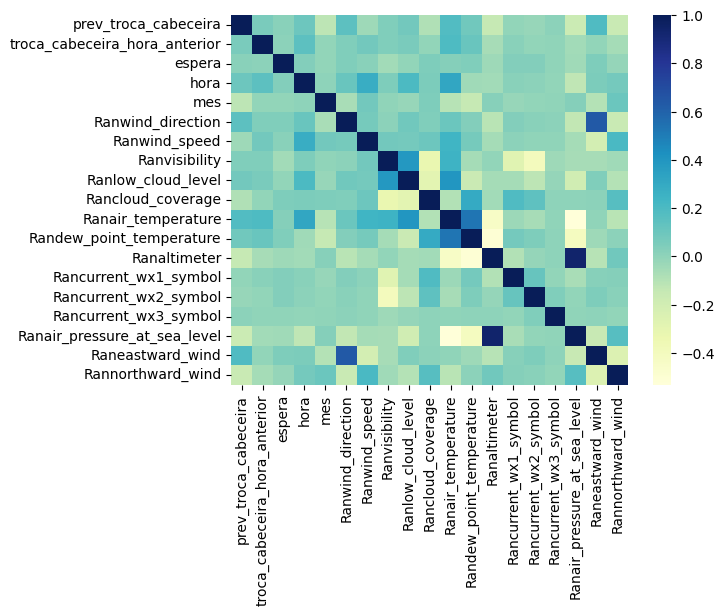

In [129]:
# df = df.dropna()
sns.heatmap(df_treino.select_dtypes('number').corr(), cmap="YlGnBu")

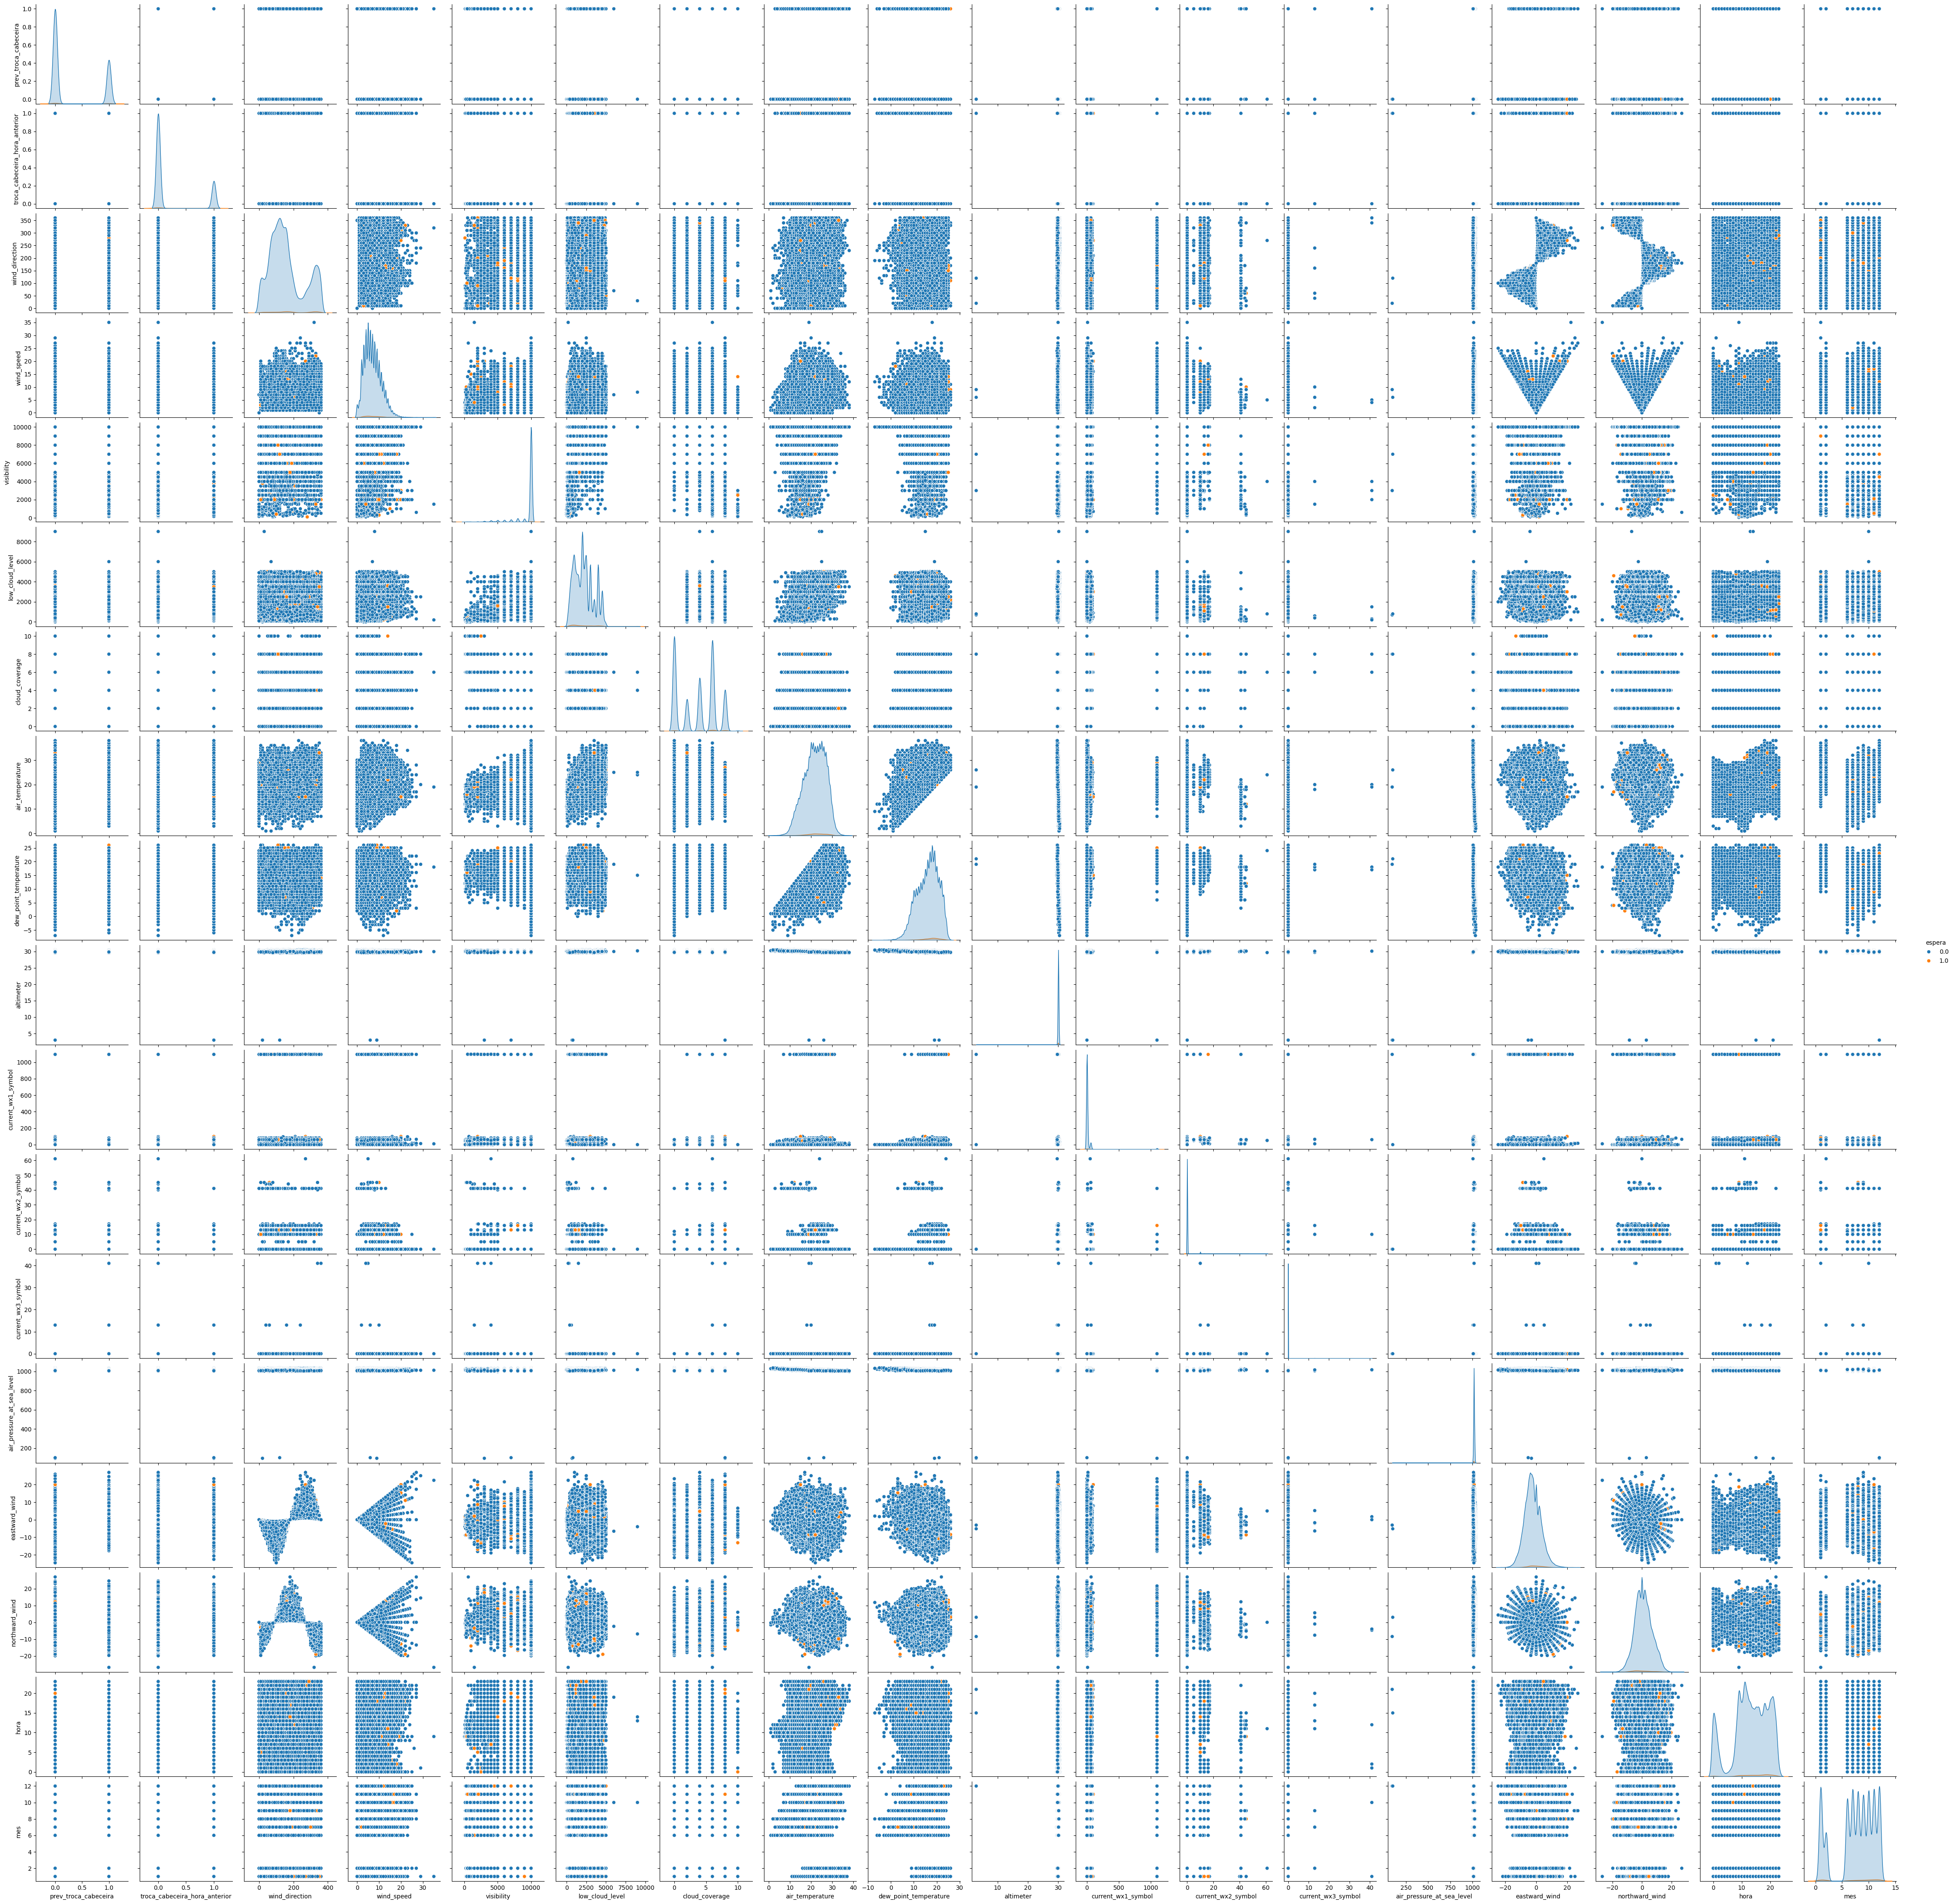

In [19]:
sns.pairplot(df_treino, hue='espera')

Vemos que a maior parte das variáveis não apresentam dependência duas a duas, mas algumas das variáveis tem correlação entre si, embora não linear. Ainda mais, não é possível identificar variáveis com alto poder preditivo para a resposta

Agora, para os modelos, como a variável resposta é desbalanceada, vamos rebalancear os dados usando SMOTEENN. Para isso, precisamos criar colunas _dummies_ para as variáveis categóricas e separamos a base em treinamento e teste, usando uma proporção de 30%

In [ ]:
df_dummies = pd.get_dummies(df_treino, columns=['origem', 'destino', 'Ranlow_cloud_type'])
df_train, df_test = train_test_split(df_dummies, test_size=0.3)
smoteenn = SMOTEENN()
x_smoteenn, y_smoteenn = smoteenn.fit_resample(df_train.drop(columns='espera'), df_train['espera'])
train_smoteenn = x_smoteenn
train_smoteenn['espera'] = y_smoteenn
train_smoteenn.to_csv('./treino_smoteenn.csv')
df_test.to_csv('./teste.csv')

In [24]:
df_reg_train = pd.read_csv('./treino_smoteenn.csv')
df_reg_test = pd.read_csv('./teste.csv')
del df_reg_test['Unnamed: 0.1'], df_reg_test['Unnamed: 0']
del df_reg_train['Unnamed: 0.1'], df_reg_train['Unnamed: 0']

In [25]:
df_reg_test = df_reg_test[df_reg_train.columns]

# Modelagem

Criamos um _dataframe_ com as colunas que vão ser usadas

In [26]:
x_test = df_reg_test[['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior',
       'hora', 'mes', 'Ranwind_direction', 'Ranwind_speed',
       'Ranvisibility', 'Ranlow_cloud_level', 'Rancloud_coverage',
       'Ranair_temperature', 'Randew_point_temperature', 'Ranaltimeter',
       'Rancurrent_wx1_symbol', 'Rancurrent_wx2_symbol',
       'Rancurrent_wx3_symbol', 'Ranair_pressure_at_sea_level',
       'Raneastward_wind', 'Rannorthward_wind', 'origem_SBBR', 'origem_SBCF',
       'origem_SBCT', 'origem_SBFL', 'origem_SBGL', 'origem_SBGR',
       'origem_SBKP', 'origem_SBPA', 'origem_SBRF', 'origem_SBRJ',
       'origem_SBSP', 'origem_SBSV', 'destino_SBBR', 'destino_SBCF',
       'destino_SBCT', 'destino_SBFL', 'destino_SBGL', 'destino_SBGR',
       'destino_SBKP', 'destino_SBPA', 'destino_SBRF', 'destino_SBRJ',
       'destino_SBSP', 'destino_SBSV', 'Ranlow_cloud_type_BKN',
       'Ranlow_cloud_type_FEW', 'Ranlow_cloud_type_NCD',
       'Ranlow_cloud_type_NSC', 'Ranlow_cloud_type_OVC',
       'Ranlow_cloud_type_SCT', 'Ranlow_cloud_type_VV']]

y_test = df_reg_test['espera']

In [27]:
x_smoteenn = df_reg_train.drop(['espera'], axis=1)
y_smoteenn = df_reg_train['espera']

In [28]:
x_smoteenn = np.asarray(x_smoteenn).astype(np.float32)
y_smoteenn = np.asarray(y_smoteenn).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

## Rede neural

Testamos um modelo de rede neural sequencial. Usamos uma camada de entrada (40 neurônios, ativação ReLU) e uma de saída (1 neurônio, ativação sigmoide) com a _loss function_ _binary crossentropy_ e o otimizador adam

In [ ]:
model = Sequential()
model.add(Dense(40, activation='relu', input_shape=(49,)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 40)                2000      
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2041 (7.97 KB)
Trainable params: 2041 (7.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#treinando com 150 épocas e batch de tamanho 200
test_results = model.fit(x_smoteenn, y_smoteenn, validation_data=(x_test, y_test), epochs=150, batch_size=200)

Epoch 1/150
1301/1301 [==============================] - 4s 3ms/step - loss: 0.7305 - accuracy: 0.7798 - val_loss: 0.4505 - val_accuracy: 0.8383
Epoch 2/150
1301/1301 [==============================] - 3s 3ms/step - loss: 0.4474 - accuracy: 0.8440 - val_loss: 0.1285 - val_accuracy: 0.9776
Epoch 3/150
1301/1301 [==============================] - 4s 3ms/step - loss: 0.4417 - accuracy: 0.8673 - val_loss: 2.4262 - val_accuracy: 0.2381
Epoch 4/150
1301/1301 [==============================] - 4s 3ms/step - loss: 0.7060 - accuracy: 0.8838 - val_loss: 0.1967 - val_accuracy: 0.9788
Epoch 5/150
1301/1301 [==============================] - 4s 3ms/step - loss: 0.3294 - accuracy: 0.8952 - val_loss: 0.4417 - val_accuracy: 0.7829
Epoch 6/150
1301/1301 [==============================] - 5s 4ms/step - loss: 0.4801 - accuracy: 0.8784 - val_loss: 0.3405 - val_accuracy: 0.8417
Epoch 7/150
1301/1301 [==============================] - 3s 3ms/step - loss: 0.4283 - accuracy: 0.8928 - val_loss: 0.1963 - val_ac

Analisamos a matriz de confusão e o escore F1:

1985/1985 [==============================] - 5s 3ms/step


Text(113.9222222222222, 0.5, 'Actual label')

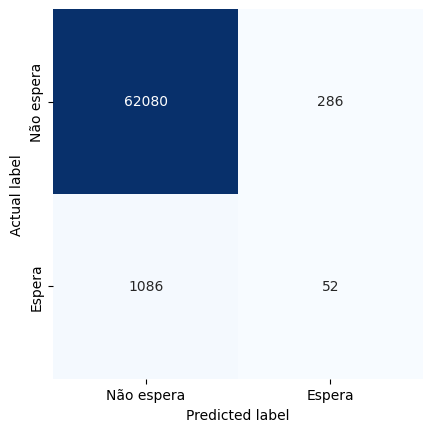

In [ ]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Não espera', 'Espera']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [ ]:
metrics.f1_score(y_test, y_predicted)

0.07046070460704608

Vemos que o modelo não identifica bem a variável resposta, como esperado pela análise exploratória

## Naive Bayes

Usamos o modelo de _Naive_ Bayes, usando o _kernel_ gaussiano

In [42]:
# Cria um classificador Bayes ingênuo (Naive Bayes)
gnb = naive_bayes.GaussianNB()

# Treina o classificador na base de treinamento
gnb.fit(df_reg_train.loc[:, df_reg_train.columns != 'espera'], df_reg_train['espera'])

GaussianNB()

In [44]:
# Predição dos rótulos na base de teste
predito = gnb.predict(df_reg_test.loc[:, df_reg_test.columns != 'espera'])


print(metrics.classification_report(predito, df_reg_test['espera']))

              precision    recall  f1-score   support

         0.0       0.65      0.99      0.79     41088
         1.0       0.70      0.04      0.07     22416

    accuracy                           0.65     63504
   macro avg       0.68      0.51      0.43     63504
weighted avg       0.67      0.65      0.53     63504



Obtemos um resultado muito próximo da rede neural.

## KNN

Usamos um KNN com _RandomizedSearchCV_ otimizando o escore F1. Para isso, primeiro usamos um padronizador

In [77]:
from sklearn.preprocessing import StandardScaler

classifier = model_selection.RandomizedSearchCV(neighbors.KNeighborsClassifier(),
                                          {'n_neighbors': range(3, 14)}, n_jobs=-1,
                                          scoring='f1', verbose=1)

# treina o classificador com os dados de treinameto
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(df_reg_train.loc[:, df_reg_train.columns != 'espera'])
classifier.fit(X_train_scale, df_reg_train['espera'])

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': range(3, 14)},
                   scoring='f1')

In [34]:
df_treino
del df_treino['Unnamed: 0'], df_treino['flightid']

In [78]:
# Obtém predições para a base de teste
X_test_scale = scaler.transform(df_reg_test.loc[:, df_reg_train.columns != 'espera'])
predito = classifier.predict(X_test_scale)
print(f'melhores parametros: {classifier.best_params_}')
print(metrics.classification_report(predito, df_reg_test['espera']))

melhores parametros: {'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     62928
         1.0       0.10      0.19      0.13       576

    accuracy                           0.98     63504
   macro avg       0.55      0.59      0.56     63504
weighted avg       0.98      0.98      0.98     63504



Temos um modelo ligeiramente melhor do que os anteriores

## RandomForest
Testamos uma floresta aleatória, também usando uma busca randomizada no espaço de hiperparâmetros:

In [ ]:
clf = ensemble.RandomForestClassifier(class_weight='balanced')
param_grid = {
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5),
    'n_estimators': range(60, 200, 20)
}

grid = model_selection.RandomizedSearchCV(clf, param_grid,
                                          scoring='f1', n_jobs=-1, n_iter=100, verbose=1)

grid.fit(df_reg_train.loc[:, df_reg_train.columns != 'espera'], df_reg_train['espera'])
# Obtém predições para a base de teste

In [136]:
predito = grid.predict(df_reg_test.loc[:, df_reg_test.columns != 'espera'])
print(f'melhores parametros: {grid.best_params_}')
print(metrics.classification_report(df_reg_test['espera'], predito))

melhores parametros: {'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 23}
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     62366
         1.0       0.30      0.29      0.30      1138

    accuracy                           0.98     63504
   macro avg       0.64      0.64      0.64     63504
weighted avg       0.97      0.98      0.97     63504



Vemos que esse modelo é muito melhor que os anteriores.

## XGBoost
Testamos agora o XGBoost, também com busca randomizada de hiperparâmetros

In [110]:
xgb = XGBClassifier(learning_rate = 0.01,
                    random_state=0, n_jobs=2, eval_metric='aucpr')

param_grid = { 'n_estimators': range(550, 700, 10),
    'max_depth': range(1, 50, 2),
}

grid_xgb = model_selection.RandomizedSearchCV(xgb, param_grid, scoring='f1', n_jobs=-1, n_iter=10, verbose=4)
grid_xgb.fit(df_reg_train.loc[:, df_reg_train.columns != 'espera'], df_reg_train['espera'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END .....max_depth=3, n_estimators=620;, score=0.897 total time=  50.0s
[CV 3/5] END ....max_depth=37, n_estimators=620;, score=0.999 total time= 5.8min


/home/lucas/.cache/pypoetry/virtualenvs/previsao-atraso-voo-JILE6Zxy-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END .....max_depth=3, n_estimators=620;, score=0.895 total time=  49.1s
[CV 2/5] END ....max_depth=37, n_estimators=620;, score=0.999 total time= 6.1min
[CV 3/5] END .....max_depth=3, n_estimators=620;, score=0.895 total time=  42.0s
[CV 5/5] END .....max_depth=3, n_estimators=620;, score=0.893 total time=  42.3s
[CV 4/5] END ....max_depth=37, n_estimators=620;, score=0.999 total time= 5.8min
[CV 1/5] END .....max_depth=3, n_estimators=620;, score=0.877 total time=  48.6s
[CV 1/5] END ....max_depth=37, n_estimators=620;, score=0.985 total time= 5.8min
[CV 5/5] END ....max_depth=37, n_estimators=620;, score=0.999 total time= 5.6min
[CV 4/5] END .....max_depth=1, n_estimators=640;, score=0.795 total time=  26.2s
[CV 1/5] END .....max_depth=7, n_estimators=640;, score=0.949 total time= 1.4min
[CV 4/5] END .....max_depth=7, n_estimators=640;, score=0.973 total time= 1.2min
[CV 3/5] END .....max_depth=3, n_estimators=580;, score=0.889 total time=  47.3s
[CV 1/5] END ....max_depth=4

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=2,
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 50, 2),
                                        'n_estimators': range(550, 700, 10)},
                   scoring='f1', verbose=4)

In [111]:
predito = grid_xgb.predict(df_reg_test.loc[:, df_reg_test.columns != 'espera'])
print(f'melhores parametros: {grid_xgb.best_params_}')
print(metrics.classification_report(predito, df_reg_test['espera']))

melhores parametros: {'n_estimators': 680, 'max_depth': 19}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     62515
           1       0.27      0.32      0.29       989

    accuracy                           0.98     63504
   macro avg       0.63      0.65      0.64     63504
weighted avg       0.98      0.98      0.98     63504



O modelo obtido é bem próximo do _RandomForest_, mas ainda um pouco pior

## HGBC
Por fim, testamos o HistGradientBoostingClassifier, inspirado no LightGBM, também usando uma busca randomizada dos melhores hiperparâmetros:

In [ ]:
hgbc = HistGradientBoostingClassifier(scoring='f1', class_weight='balanced', max_leaf_nodes=None)

param_grid = {'min_samples_leaf': range(3, 15, 1),
    'max_features': np.linspace(0.1, 1, 5)   
}

grid_hgbc = model_selection.RandomizedSearchCV(hgbc, param_grid, scoring='f1', n_jobs=-1, n_iter=10, verbose=3)
grid_hgbc.fit(df_reg_train.loc[:, df_reg_train.columns != 'espera'], df_reg_train['espera'])

In [95]:
predito = grid_hgbc.predict(df_reg_test.loc[:, df_reg_test.columns != 'espera'])
print(f'melhores parametros: {grid_hgbc.best_params_}')
print(metrics.classification_report(predito, df_reg_test['espera']))

melhores parametros: {'min_samples_leaf': 11, 'max_features': 0.325}
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     62318
         1.0       0.30      0.29      0.30      1186

    accuracy                           0.97     63504
   macro avg       0.65      0.64      0.64     63504
weighted avg       0.97      0.97      0.97     63504



Esse modelo tem resultados quase idênticos a Floresta aleatória.

# Criação do csv para a competição:

Prevemos os dados para a base de teste, a partir das predições do HGBC

In [13]:
predito = hgbc.predict(pd.get_dummies(df_teste.loc[:, (df_teste.columns != 'espera') & (df_teste.columns != 'flightid')]))

In [14]:
df_teste['predito'] = predito
entrega = df_teste[['flightid', 'predito']]

/tmp/ipykernel_403523/3641122067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['predito'] = predito


In [18]:
entrega.reset_index()[['flightid', 'predito']].to_csv('./submissao.csv', index=False)